In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
import scipy, scipy.stats
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.01, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [10]:
x_train.shape

(500, 160, 10, 1)

In [11]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [13]:
latent_dim = 10
epsilon_std = 1.0

In [14]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [15]:
batch_size = 128
epochs = 500

In [16]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [17]:
# io.save_dict('../logs/','train_loss', history)

In [18]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [19]:
vae.load_weights(fn)

In [20]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

n_bars = 1.250000, 	length=50.000000


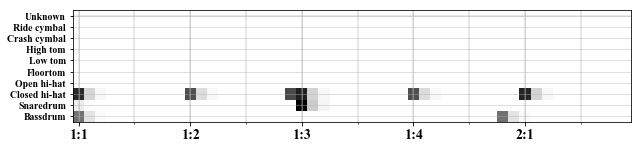

n_bars = 1.250000, 	length=50.000000


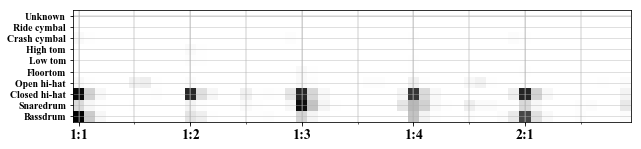

n_bars = 1.250000, 	length=50.000000


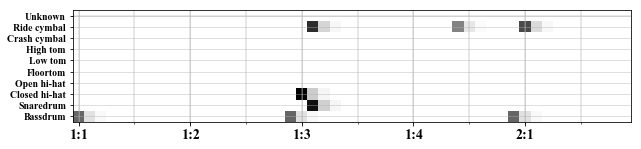

n_bars = 1.250000, 	length=50.000000


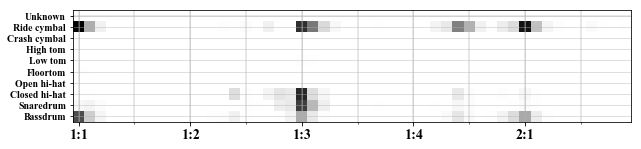

In [21]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [22]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [23]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [24]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Style transfer

In [25]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [26]:
# dn = config.plots_dir + 'transformations.pkl'
# io.save(transformations, fn)
# # transformation_extraction.save_to_disk(transformations, dn, v=1)

# fn = config.plots_dir + 'min_transformations.pkl'
# io.save(min_transformations, fn)
# # transformation_extraction.save_to_disk(min_transformations, dn)

In [27]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)
len(list(transformations.keys()))

71

(array([469.,  99., 133.,  28.,  72., 100., 177.,  72.,  55., 286.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

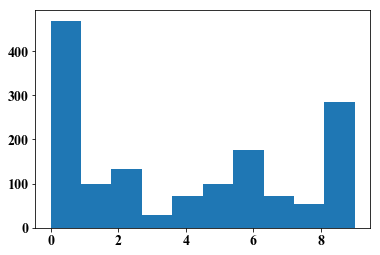

In [28]:
plt.hist(best_dims)

In [29]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [30]:
list(transformations.keys())[:3]

['04 Country/01 Calvin 148BPM',
 "01 Rock'n'Roll/07 Thwag 170BPM",
 '03 Traditional Pop/07 Lester Lee 133BPM']

In [31]:
len(transformations.keys())

71

In [32]:
# io.save(result, config.plots_dir + 'ncd_evaluation_results.pkl')
labelled_result = io.load(config.plots_dir + 'ncd_evaluation_AB.pkl')
labelled_result_min = io.load(config.plots_dir + 'ncd_evaluation_AB_min.pkl')
labelled_result_AA = io.load(config.plots_dir + 'ncd_evaluation_AA.pkl')
labelled_result_AA_min = io.load(config.plots_dir + 'ncd_evaluation_AA_min.pkl')
len(list(labelled_result.keys()))

71

In [33]:
def sample_dict(d, i=0):
    k = list(d.keys())[i]
    return k, d[k]

In [34]:
# utils.reload(utils)
labelled_result = utils.clean_dict(labelled_result, r=2, verbose=1)

In [35]:
# utils.reload(utils)
sample = utils.get(labelled_result, i=10)[0]
sample

'02 Blues/01 Booze 92BPM'

In [36]:
# labelled_result[sample]

In [37]:
genre_a = utils.get(labelled_result[sample])[0]
genre_b,_, scores = utils.get(labelled_result[sample][genre_a])
scores_min = utils.get(labelled_result[sample][genre_a])[2]
xlabels = np.round(list(scores.keys()), 2)
genre_a, genre_b

('02 Blues/01 Booze 92BPM', '02 Blues/05 Cadillac 128BPM')

In [38]:
# # for k,v in scores.items():
# #     print('%s: \t%f' % (k,v))
# print(xlabels)
# plot.custom({sample: list(scores.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01, show=True)

In [39]:
# plot.custom({sample: list(scores_min.values())}, options={'x_labels': xlabels},
#             type_='bar', y_scale_margin=0.01, show=True)

In [40]:
genre_dict[sample], sample

([70, 71, 72, 73, 74, 75, 76], '02 Blues/01 Booze 92BPM')

Original


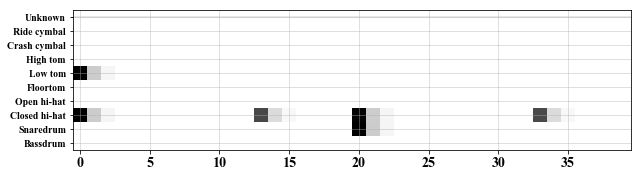

Identity (transformation)


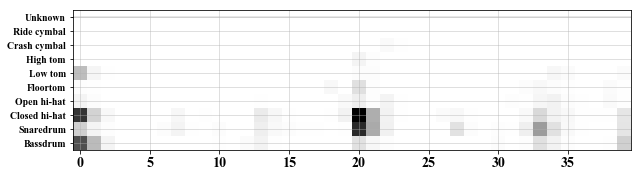

In [41]:
# utils.reload(plot, midi.pitches)
z_sample = x_train_encoded[genre_dict[genre_a][0]]
print('Original')
plot.single(x_train[genre_dict[sample][0]][:40])
print('Identity (transformation)')
plot.single(generator.predict(np.array([z_sample]))[0,:40]);

In [42]:
transformation = transformations[genre_a][genre_b]
min_transformation = min_transformations[genre_a][genre_b]
z_transformed = []
z_transformed_min = []
d = {}
for a in [0, 0.125, 0.2, 0.21, 0.22, 0.24]:
    z_ = models.apply_transformation(z_sample, transformation, a)
    z_transformed.append(z_)
    z_ = models.apply_transformation(z_sample, min_transformation, a)
    z_transformed_min.append(z_)

x_generated = generator.predict(np.array(z_transformed))
x_generated_min = generator.predict(np.array(z_transformed_min))

02 Blues/01 Booze 92BPM 
  02 Blues/01 Booze 92BPM 	-> 02 Blues/05 Cadillac 128BPM 
n_bars = 2.500000, 	length=100.000000


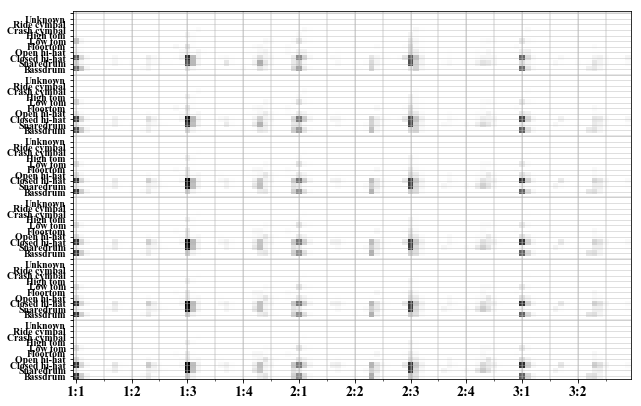

In [43]:
print('%s \n  %s \t-> %s '%(sample, genre_a, genre_b))
# latent_space = models.gen_latent(generator, latent_dim=latent_dim, n=3, m=2, plot_result=True)
plot.multi(x_generated, crop_size=100)

n_bars = 2.500000, 	length=100.000000


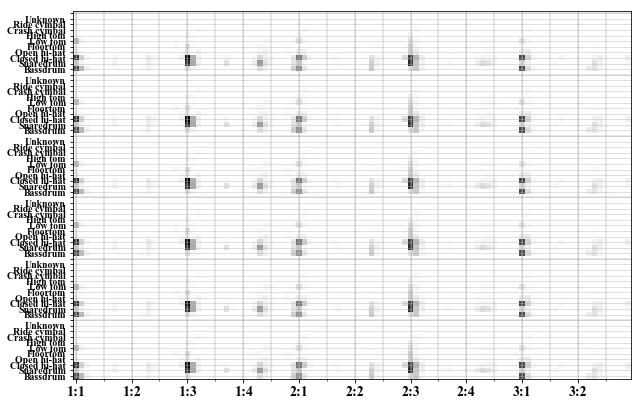

In [44]:
plot.multi(x_generated_min, crop_size=100)

In [45]:
# # utils.reload(midi, midi.decode)
# for i in range(x_generated.shape[0]):
#     x_ = x_generated[i]
#     mid = midi.decode.track(context, x_)
#     io.export_midifile(mid, config.export_dir + ('x-generated-%i'%i))
#     x_ = x_generated_min[i]
#     mid = midi.decode.track(context, x_)    
#     io.export_midifile(mid, config.export_dir + ('x-generated_min-%i'%i))    

In [134]:
utils.reload(utils, plot)
def summarize(data, regression_line=True, p_value=0.05):
    """data :: {samples: {genre a: {genre b: grid}}}
    grid = {parameter: outcome}
    
    return :: {parameter: [value] }
    """
    regression_result = collections.defaultdict(list)
    regression_result_alt = []
    slope_is_zero = 0
    slope_is_nonzero = 0
    summary = collections.defaultdict(list)
    for original in data.keys():
        for genre_a in data[original].keys():
            for genre_b, grid in data[original][genre_a].items():
                x,y = [], []
                for k,v in grid.items():
                    summary[k].append(v)
                    x.append(k)
                    y.append(v)
                _line, stats = utils.regression(y, x, line=False)
                # p_value for H0: slope = 0
                if stats['p_value'] < p_value:
                    slope_is_zero += 1
                else:
                    slope_is_nonzero += 1
                for k,v in stats.items():
                    regression_result[k].append(v)
        
                # regression between k0 and k1
                k0,k1 = 0, sorted(grid.keys())[1]
                diff = (grid[k1] - grid[k0]) / grid[k0] + 1
#                 if diff < 0:
#                     print(diff,'diff')
                regression_result_alt.append(diff)
                    

    r_mean = utils.summary_multi(regression_result, mode=dict)['mean']
    regression_result['slope_is_zero'] = slope_is_zero / (slope_is_zero + slope_is_nonzero)
    print('regression_result_alt', np.mean(regression_result_alt))
    print(' ', np.median(regression_result_alt))
    print(' ', min(regression_result_alt))    

    return summary, r_mean, regression_result

def evaluate(data, verbose=0):
    """
    data :: {parameter: [value] }
    return :: {statistic: {parameter: value}}
    """
    result = utils.summary_multi(data, mode=list)
    std = []
    for k,v in data.items():
        std.append(np.std(v))
    
    result['std'] = std
    if verbose: 
        print(result['mean'])
    return result

In [135]:
result, result_r, rs1 = summarize(labelled_result)
result_min, result_min_r, rs2 = summarize(labelled_result_min)
result_AA, result_AA_r, rs3 = summarize(labelled_result_AA)
result_AA_min, result_AA_min_r, rs4 = summarize(labelled_result_AA_min)


xlabels = np.round(list(result.keys()), 3)
summary = evaluate(result)
summary_min = evaluate(result_min)
summary_AA = evaluate(result_AA)
summary_AA_min = evaluate(result_AA_min)

summary_ = summary.copy() # {'Mean': summary['mean'], 'Median': summary['median']}
summary_min_ = summary_min.copy()
summary_.pop('std')
summary_min_.pop('std');

regression_result_alt 0.9991309874922625
  0.9989870025592168
  0.928597317868793
regression_result_alt 0.9992576163508459
  0.9995955919522799
  0.9583238958097395
regression_result_alt 2.5882627129020066
  2.5368602010590497
  1.3334958802631154
regression_result_alt 1.5740370857133306
  1.0644549763033175
  0.8757094215052914


In [48]:
def test_per_transformation(d1, d2, f=scipy.stats.ttest_rel, pvalue=0.05):
    # data :: {param: ordered list of scores}
    # return part of transformations that is significantly different
    significant = []
    greater = []
    greater_and_s = []
    params = list(d1.keys())
    list_gen = lambda i, d: [d[k][i] for k in params]
    for i,_ in enumerate(d1[params[0]]):
        list1 = list_gen(i,d1)
        list2 = list_gen(i,d2)
        t, p = f(list1, list2)
        if p < pvalue:
            significant.append(1)
        else:
            significant.append(0)
        if np.mean(list1) > np.mean(list2):
            greater.append(1)
            if p < pvalue:
                greater_and_s.append(1)
        else:
            greater.append(0)
            greater_and_s.append(0)
            

    print(np.mean(greater), np.mean(significant), np.mean(greater_and_s))

print('A*->B')
test_per_transformation(result, result_min)
print('A*->A')
test_per_transformation(result_AA, result_AA_min)

A*->B
0.43930248155600266 0.49966465459423204 0.26730937773882557
A*->A
0.8477531857813548 0.6961770623742455 0.8195548489666137


In [49]:
import scipy,scipy.stats

In [50]:
utils.reload(utils)
for r1, r2 in [(rs1,rs2), (rs3,rs4)]:
    print('\n',r1['slope_is_zero'], r2['slope_is_zero']) # half of the slopes are significant
    for stat in ['slope', 'intercept']:
        print(stat, ':\t', np.mean(r1[stat]) > np.mean(r2[stat]),np.mean(r1[stat]), np.mean(r2[stat]))
#         print(' ',utils.ttest(r1[stat], r2[stat], f=scipy.stats.ttest_rel))


 0.5828303152246814 0.3876592890677398
slope :	 False -0.011321933872654557 -0.009946671630258485
intercept :	 True 0.9728306242712416 0.9724698982712016

 0.6955063715627096 0.8685446009389671
slope :	 True 0.19808664059097372 0.16685609295200385
intercept :	 True 0.8261628412040783 0.5198823294636655


In [51]:
io.save_dict(config.results_dir, 'ncd_result-summary', summary)
io.save_dict(config.results_dir, 'ncd_result_min-summary', summary_min)
io.save_dict(config.results_dir, 'ncd_result_AA-summary', summary_AA)
io.save_dict(config.results_dir, 'ncd_result_AA-min-summary', summary_AA_min)

'../results/ncd_result_AA-min-summary.csv'

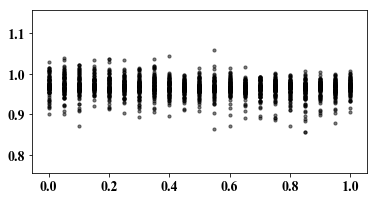

In [52]:
def scatter2(result, n=100, show=False):
    # result :: {scalar: scores}
    x, y = [], []
    for x1,ys in result.items():
        np.random.shuffle(ys)
        y.extend([y1 for y1 in ys[:n]])
        x.extend([x1 for _ in ys[:n]])
    if show:
        plt.scatter(x,y, alpha=0.5, s=10)
    return x,y
# note that this graph suggests that the std is large
# but, the samples are related
x,y = scatter2(result)
plot.custom({'Mean': y}, options={'x_ticks':x}, type_='scatter', min_y_scale=None, max_y_scale=None, show=True, s=10)

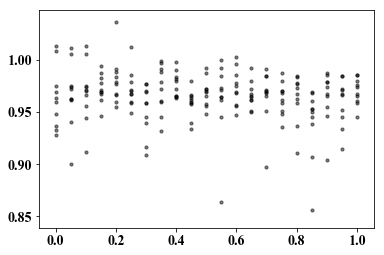

In [53]:
utils.reload(plot, utils)
def select_from_dict(d={}, i=0, activation=lambda x: x):
    # select first value for every key in d
    return {k:activation(v[i]) for k,v in d.items()}

for i in range(10):
    result1 = select_from_dict(result, i, activation=lambda x: [x])
    x,y = scatter2(result1)
    plot.scatter({i:y}, options={'x_ticks':x}, v=0, alpha=0.5, color='black', s=10)

In [54]:
xlabels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [55]:
# options = {'x_labels': xlabels, 'x_label':'Transformation intensity', 'y_label': 'ncd', 'legend':True}
# plot.custom(summary_, 'NCD', options,
#             type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

In [56]:
# plot.custom(summary_, 'NCD', options,
#             type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

In [57]:
xticks = np.arange(len(xlabels))

In [192]:
utils.reload(plot)
figsize = (10,2)
plots = [('',summary['mean'],result_r),('',summary_min['mean'],result_min_r),
                ('',summary_AA['mean'],result_AA_r),('',summary_AA_min['mean'],result_AA_min_r)]    
# # custom(summary, 'NCD', options, relative=True, show=True)
# plot.custom({'Mean':summary['mean']}, 'NCD', options, 
#             type_='bar', min_y_scale=None, max_y_scale=None, y_scale_margin=0.001, figsize=figsize, show=True)

full, min
-0.011
-0.01
0.198
0.167


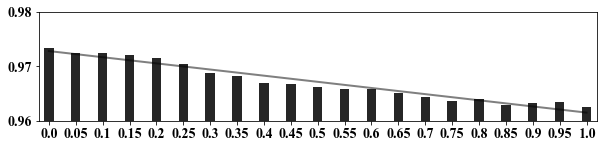

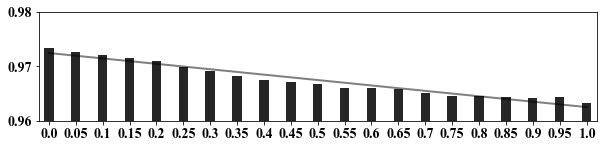

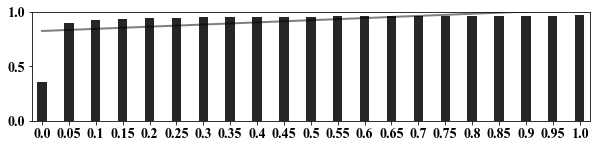

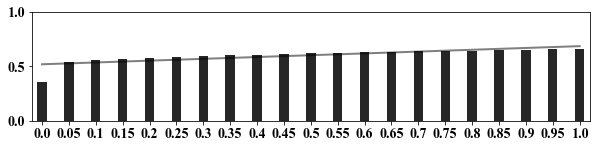

In [193]:
options = {'x_labels': xlabels}
min_y_scale = 0.96
max_y_scale = 0.98
i = 0
print('full, min')
for name, d, r in plots:
    if i > 1:
        min_y_scale = 0
        max_y_scale = 1
    plot.custom({'_':d}, name, options, type_='bar', 
                min_y_scale=min_y_scale, max_y_scale=max_y_scale, y_scale_margin=0.001, figsize=figsize, 
                show=True)
    line = utils.gen_line(xlabels, r['slope'], r['intercept'])
    plot.line(xticks, line)
    print(round(r['slope'],3))
    i += 1

-0.011321933872654557
-0.009946671630258485
0.19808664059097372
0.16685609295200385


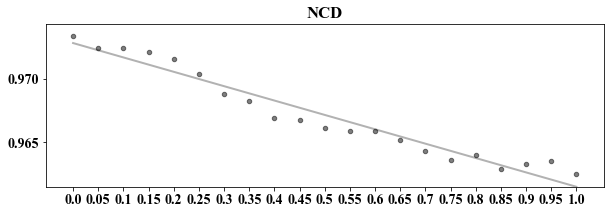

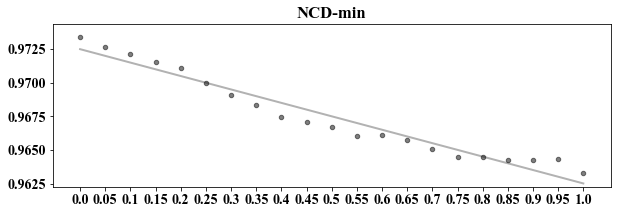

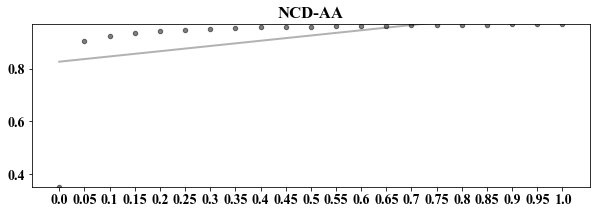

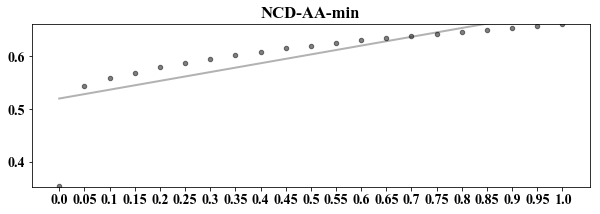

In [60]:
utils.reload(plot)
options = {'x_labels': xlabels, 'x_ticks': xlabels}
for name, d, r in plots:
    plot.custom({'_':d}, name, options, 
            type_='scatter', min_y_scale=None, max_y_scale=None, y_scale_margin=0.001, figsize=figsize,
            show=True, s=20)
    line = utils.gen_line(xlabels, r['slope'], r['intercept'])
    plot.line(xlabels, line)
    print(r['slope'])

In [61]:
# import scipy.stats

In [62]:
# x = np.random.random(10)
# y = np.random.random(10)
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
# slope, intercept, r_value, p_value, std_err

In [63]:
# plt.scatter(xlabels, summary_AA_min['mean'])

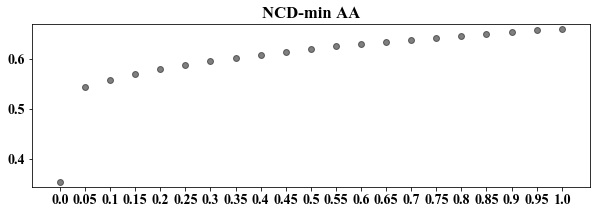

In [64]:
utils.reload(plot)
figsize = (10,3)
options = {'x_labels': xlabels, 'x_ticks': xlabels}
# custom(summary, 'NCD', options, relative=True, show=True)
plot.custom({'Mean':summary_AA_min['mean']}, 'NCD-min AA', options, 
            type_='scatter', min_y_scale=None, max_y_scale=None, y_scale_margin=0.01, figsize=figsize, show=True)

In [65]:
def plot_w_regress(x, y, **kwargs):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    print(slope, intercept, r_value, p_value, std_err)
    plt.scatter(x, y, **kwargs)
    line = [intercept + slope * a for a in x]
    plt.plot(x, line)

-0.011321933872654514 0.9728306242712416 -0.9755162530163244 5.886771109404901e-14 0.0005855831195340947


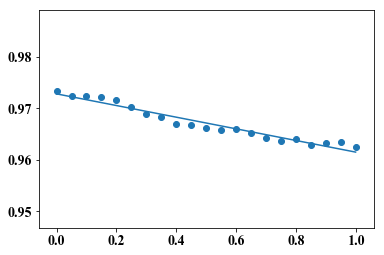

In [66]:
plot_w_regress(np.linspace(0,1,len(summary['mean'])), summary['mean'])

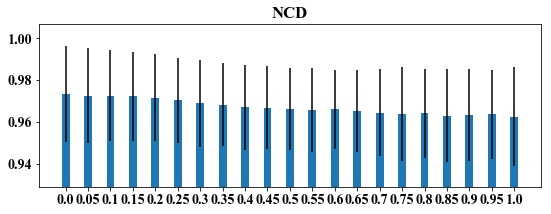

In [67]:
# utils.reload(plot)
options = {'x_labels': xlabels,}
# custom(summary, 'NCD', options, relative=True, show=True)
std = {'Mean': summary['std'], 'Median': summary['std']}
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar',
            std=std, figsize=(9,3),min_y_scale=None, max_y_scale=None, y_scale_margin=0.01, show=True)

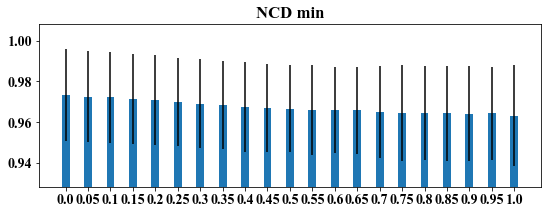

In [68]:
std_min = {'Mean': summary_min['std'], 'Median': summary_min['std']}
plot.custom({'Mean':summary_min['mean']}, 'NCD min', options, type_='bar',
            std=std_min, figsize=(9,3),min_y_scale=None, max_y_scale=None, y_scale_margin=0.01, show=True)

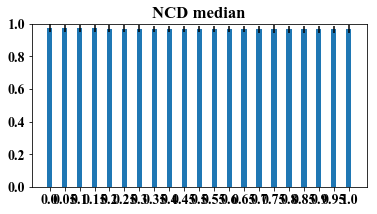

In [69]:
plot.custom({'Median':summary['median']}, 'NCD median', options, type_='bar', std=std, show=True)

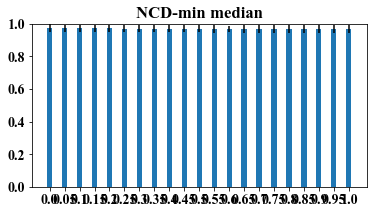

In [70]:
plot.custom({'Median':summary_min['median']}, 'NCD-min median', options, type_='bar', std=std_min, show=True)

In [71]:
result.keys()

dict_keys([0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0])

In [72]:
# assume all distributions are related, do not shuffle
# i.e. param1[0] is related to param2[0]
def evaluate(data, base_k=0, f=scipy.stats.ttest_rel, p=0.05,win_c=lambda x,y: x>y):
    result = {}
    base_v = data[base_k]
    for k,v in data.items():
        if len(v) < 1:
            raise(ValueError('Warning: len(v) == %i for k: %s'%(len(v), str(k))))
        if not k == base_k:
            score = scipy.stats.ttest_rel(base_v, v)
            won = win_c(np.mean(base_v), np.mean(v))
            significant = score.pvalue < p
            result['%s/%s' % (base_k,k)] = (won, significant)
            print('%s vs %s: \t' % (base_k, k), won, significant, round(score.pvalue,4))

In [73]:
evaluate(result)

0 vs 0.05: 	 True False 0.2835
0 vs 0.1: 	 True False 0.2443
0 vs 0.15000000000000002: 	 True False 0.135
0 vs 0.2: 	 True True 0.0225
0 vs 0.25: 	 True True 0.0002
0 vs 0.30000000000000004: 	 True True 0.0
0 vs 0.35000000000000003: 	 True True 0.0
0 vs 0.4: 	 True True 0.0
0 vs 0.45: 	 True True 0.0
0 vs 0.5: 	 True True 0.0
0 vs 0.55: 	 True True 0.0
0 vs 0.6000000000000001: 	 True True 0.0
0 vs 0.65: 	 True True 0.0
0 vs 0.7000000000000001: 	 True True 0.0
0 vs 0.75: 	 True True 0.0
0 vs 0.8: 	 True True 0.0
0 vs 0.8500000000000001: 	 True True 0.0
0 vs 0.9: 	 True True 0.0
0 vs 0.9500000000000001: 	 True True 0.0
0 vs 1.0: 	 True True 0.0


In [74]:
evaluate(result_min)

0 vs 0.05: 	 True True 0.0
0 vs 0.1: 	 True True 0.0
0 vs 0.15000000000000002: 	 True True 0.0
0 vs 0.2: 	 True True 0.0
0 vs 0.25: 	 True True 0.0
0 vs 0.30000000000000004: 	 True True 0.0
0 vs 0.35000000000000003: 	 True True 0.0
0 vs 0.4: 	 True True 0.0
0 vs 0.45: 	 True True 0.0
0 vs 0.5: 	 True True 0.0
0 vs 0.55: 	 True True 0.0
0 vs 0.6000000000000001: 	 True True 0.0
0 vs 0.65: 	 True True 0.0
0 vs 0.7000000000000001: 	 True True 0.0
0 vs 0.75: 	 True True 0.0
0 vs 0.8: 	 True True 0.0
0 vs 0.8500000000000001: 	 True True 0.0
0 vs 0.9: 	 True True 0.0
0 vs 0.9500000000000001: 	 True True 0.0
0 vs 1.0: 	 True True 0.0


In [75]:
evaluate(result_min, base_k=0, f=scipy.stats.ttest_ind)

0 vs 0.05: 	 True True 0.0
0 vs 0.1: 	 True True 0.0
0 vs 0.15000000000000002: 	 True True 0.0
0 vs 0.2: 	 True True 0.0
0 vs 0.25: 	 True True 0.0
0 vs 0.30000000000000004: 	 True True 0.0
0 vs 0.35000000000000003: 	 True True 0.0
0 vs 0.4: 	 True True 0.0
0 vs 0.45: 	 True True 0.0
0 vs 0.5: 	 True True 0.0
0 vs 0.55: 	 True True 0.0
0 vs 0.6000000000000001: 	 True True 0.0
0 vs 0.65: 	 True True 0.0
0 vs 0.7000000000000001: 	 True True 0.0
0 vs 0.75: 	 True True 0.0
0 vs 0.8: 	 True True 0.0
0 vs 0.8500000000000001: 	 True True 0.0
0 vs 0.9: 	 True True 0.0
0 vs 0.9500000000000001: 	 True True 0.0
0 vs 1.0: 	 True True 0.0


In [76]:
len(list(labelled_result.keys()))

71

In [77]:
# from scipy.stats import pearsonr
import scipy, scipy.stats

In [78]:
# assume all distributions are related, do not shuffle
# i.e. param1[0] is related to param2[0]
def correlation(data, f=scipy.stats.pearsonr, p=0.05, t=1004, pairs=True):
    """Compare x,y (ordered)
    x = params
    y = scores (p(y|x))
    """
    x_per_genre_a = collections.defaultdict(list)
    y_per_genre_a = collections.defaultdict(list)
    x_per_genre_b = collections.defaultdict(list)
    y_per_genre_b = collections.defaultdict(list)
    result_per_sample = []
    x_all = []
    y_all = []
    for genre_a,v1 in data.items():
        for v2 in v1.values():
            for genre_b,v3 in v2.items():
                scores = f(list(v3.keys()), list(v3.values()))
                result_per_sample.append(scores)
                # x_per_genre_a[genre_a].extend(list(v3.keys()))
                for x1,y1 in v3.items():                        
                    if x1 < t:
                        x_all.append(x1)
                        y_all.append(y1)
                        x_per_genre_a[genre_a].append(x1)
                        y_per_genre_a[genre_a].append(y1)
                        x_per_genre_b[genre_b].append(x1)
                        y_per_genre_b[genre_b].append(y1)

    result_all = f(x_all, y_all)
    print(len(x_all))
    print('a=%i, b=%i'%(len(x_per_genre_a.keys()),len(x_per_genre_b.keys())))
    # np.random.shuffle(result_per_sample)
    result_a = []
    for genre_a,x in x_per_genre_a.items():
        y = y_per_genre_a[genre_a]
        result_a.append(f(x,y))

    result_b = []
    for genre_b,x in x_per_genre_b.items():
        y = y_per_genre_b[genre_b]
        result_b.append(f(x,y))
    
    return result_all, (result_per_sample, result_a, result_b)

def f_map(data, f=np.mean, i=0, condition=lambda x: True):
    # data = [(correlation, p-value)]
    a = len([item for item in data if condition(item)])
#     print('  len=', a, a/len(data))
    return f([item[i] for item in data if condition(item)])

In [79]:
# i = 0
# for v in labelled_result.values():
#     if len(list(v.keys())) > 1:
#         print(v.keys())
#         stop
#     v_ = utils.get(v)[-1]
# #     print(v_)
#     print(len(list(v_.keys())))
# #     i += len(list(v.values()))
# i

## Correlation

Note that p1 is not normally distributed
- sample p1?

In [80]:
r, results = correlation(labelled_result_min)
print('all', r)
for correlations in results[:1]:
    print('\nmean:\t',f_map(correlations), f_map(correlations, i=1))
    print('median:\t',f_map(correlations, f=np.median), f_map(correlations, i=1, f=np.median))
    
    print('conditional; p < 0.05, n=%i'%len(correlations))
    c = lambda x: x[1] < 0.05
    mean_c = f_map(correlations, condition=c)
    mean_p = f_map(correlations, i=1, condition=c)
    median_c = f_map(correlations, f=np.median, condition=c)
    mean_p = f_map(correlations, i=1, f=np.median, condition=c)
    print('mean:\t', mean_c, mean_p)
    print('median:\t', median_c, mean_p)

# # plt.hist(correlations.values())
# plt.figure(figsize=(1,5))
# plt.scatter(np.zeros(len(correlations.values())), correlations.values(), alpha=0.2, s=10)
# plot.custom(correlations, type_='bar', show=True)

31311
a=71, b=71
all (-0.13279557312243243, 3.7007250453220155e-123)

mean:	 -0.15369097985534377 0.26996595908553234
median:	 -0.1615230102782227 0.1329953894982833
conditional; p < 0.05, n=1491
mean:	 -0.3589748905132749 0.002279353451488506
median:	 -0.5802252452351818 0.002279353451488506


In [81]:
r, results = correlation(labelled_result)
print('all', r)
for correlations in results[:1]:
    print('\nmean:\t',f_map(correlations), f_map(correlations, i=1))
    print('median:\t',f_map(correlations, f=np.median), f_map(correlations, i=1, f=np.median))
    
    print('conditional; p < 0.05, n=%i'%len(correlations))
    c = lambda x: x[1] < 0.05
    mean_c = f_map(correlations, condition=c)
    mean_p = f_map(correlations, i=1, condition=c)
    median_c = f_map(correlations, f=np.median, condition=c)
    mean_p = f_map(correlations, i=1, f=np.median, condition=c)
    print('mean:\t', mean_c, mean_p)
    print('median:\t', median_c, mean_p)

# # plt.hist(correlations.values())
# plt.figure(figsize=(1,5))
# plt.scatter(np.zeros(len(correlations.values())), correlations.values(), alpha=0.2, s=10)
# plot.custom(correlations, type_='bar', show=True)

31311
a=71, b=71
all (-0.16042399214261296, 1.541717490813033e-179)

mean:	 -0.16316267367203877 0.1690013402176915
median:	 -0.2643948885804971 0.019504021050515158
conditional; p < 0.05, n=1491
mean:	 -0.26621815481294775 0.0008952482115309032
median:	 -0.5878050680870293 0.0008952482115309032


In [82]:
"""
a=53, b=35

mean:	 -0.22071146739810515 0.2195304860319121
median:	 -0.2619200923511064 0.07234709549070571
conditional; p < 0.05, n=53
  len= 26 0.49056603773584906
mean:	 -0.39611457625938973 0.008544585172881494
median:	 -0.5383220075390692 0.008544585172881494
"""

'\na=53, b=35\n\nmean:\t -0.22071146739810515 0.2195304860319121\nmedian:\t -0.2619200923511064 0.07234709549070571\nconditional; p < 0.05, n=53\n  len= 26 0.49056603773584906\nmean:\t -0.39611457625938973 0.008544585172881494\nmedian:\t -0.5383220075390692 0.008544585172881494\n'

In [83]:
r, results = correlation(labelled_result_AA)
print('all', r)

31311
a=71, b=71
all (0.45179044764523546, 0.0)


In [84]:
r, results = correlation(labelled_result_AA_min)
print('all', r)

31311
a=71, b=71
all (0.20235143081258253, 1.2857315257464322e-286)
